In [9]:
import torch
import numpy as np

# Fixar a semente do Torch para operações específicas
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Importa e plota tensor

torch.Size([1, 1, 512, 512])


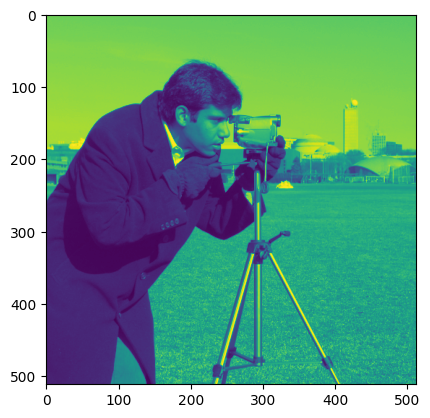

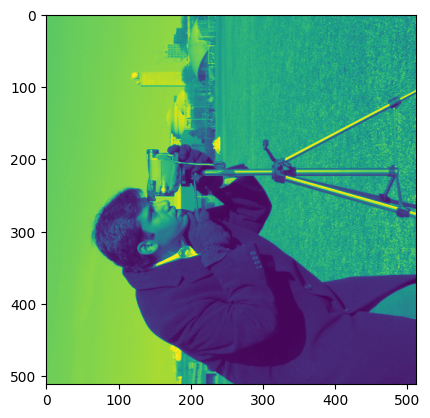

In [10]:
#First load libraries and images
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import numpy as np
import kornia
import kornia as K
import cv2
from kornia.feature import *
from time import time
import torch.optim as optim
from torch.nn import Parameter
from kornia.color import rgb_to_grayscale

from skimage import data

camera = K.image_to_tensor(data.camera(), keepdim=False)
camera = camera.float() / 255.
print(camera.shape)
timg = torch.cat([camera,torch.rot90(camera,1,dims=(2,3))], dim=0)
timg_gray = timg


plt.imshow(kornia.utils.tensor_to_image(timg[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(timg[1]))

## Aumento de dados caminho de ida e volta e reprodutibilidade

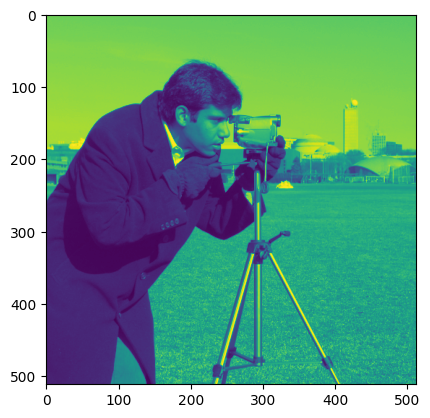

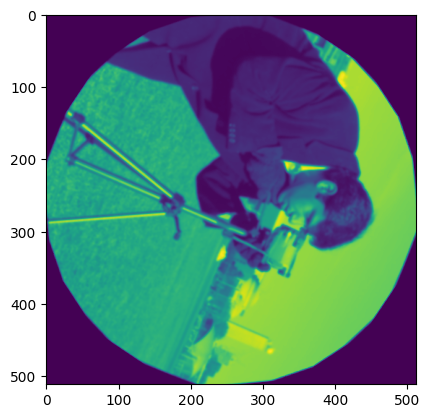

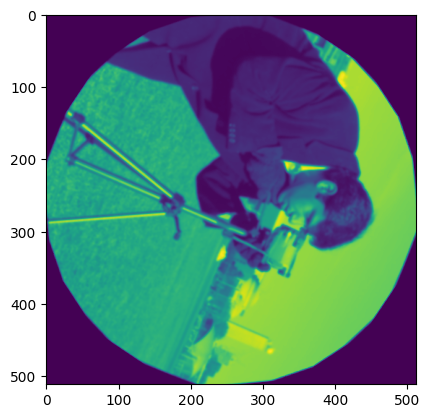

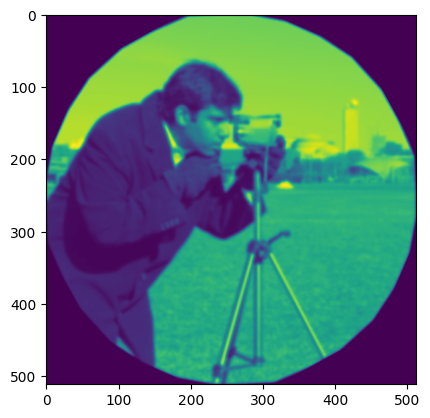

In [11]:
import kornia
img1: torch.Tensor = kornia.image_to_tensor(data.camera(), keepdim=False).float() / 255.
input = torch.cat([img1,img1], dim=0)
B,C,H,W = input.shape
mask = torch.ones(B,C,H,W)
bbox = torch.tensor([[
    [1., 1.],
    [2., 1.],
    [2., 2.],
    [1., 2.],
]]).expand(B, 1, -1, -1)
points = torch.tensor([[[1., 1.]]]).expand(2, -1, -1)
aug_list = kornia.augmentation.AugmentationSequential(
    # kornia.augmentation.ColorJiggle(0.1, 0.1, 0.1, 0.1, p=1.0),
    kornia.augmentation.RandomAffine(360, p=1.0),
    # kornia.augmentation.RandomPerspective(0.2, p=1.0),
    data_keys=["input", "mask", "bbox", "keypoints"],
    same_on_batch=False,
    random_apply=10,
)
out = aug_list(input, mask, bbox, points)
# [o.shape for o in out]
# [torch.Size([2, 3, 5, 6]), torch.Size([2, 3, 5, 6]), torch.Size([2, 1, 4, 2]), torch.Size([2, 1, 2])]
# apply the exact augmentation again.
out_rep = aug_list(input, mask, bbox, points, params=aug_list._params)
# [(o == o_rep).all() for o, o_rep in zip(out, out_rep)]
# [tensor(True), tensor(True), tensor(True), tensor(True)]
# inverse the augmentations
out_inv = aug_list.inverse(*out)
# [o.shape for o in out_inv]
# [torch.Size([2, 3, 5, 6]), torch.Size([2, 3, 5, 6]), torch.Size([2, 1, 4, 2]), torch.Size([2, 1, 2])]

plt.imshow(kornia.utils.tensor_to_image(input[0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(out[0][0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(out_rep[0][0]))
plt.figure()
plt.imshow(kornia.utils.tensor_to_image(out_inv[0][0]))

### CustonNetDetector

In [12]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
import torch
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_channel=2) -> None:
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=36)      

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, 5*[r2_act.regular_repr])     
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=3, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True)
                )
        
        self.pool1 = enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.66, stride=1, padding=0)

        feat_type_in  = self.block1.out_type
        feat_type_out = enn.FieldType(r2_act, 1*[r2_act.regular_repr])
        self.block2 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=3, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                )
        
        self.pool2 = enn.PointwiseMaxPool(feat_type_out,kernel_size=15, stride=1, padding=7)
        self.gpool = enn.GroupPooling(feat_type_out)
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        # x = self.pool2(x)
        x = self.gpool(x)   
        return x.tensor
    
model = Feature(n_channel=1)

In [13]:
temp = torch.rand(1,1,120,120)
temp = torch.cat([temp,temp],dim=0)
model = model.to(temp.device)
model(temp).shape

torch.Size([2, 1, 120, 120])

In [14]:
import torch
import kornia
from kornia.feature.scale_space_detector import get_default_detector_config, MultiResolutionDetector

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

keynet_default_config = {
    'num_filters': 8,
    'num_levels': 3,
    'kernel_size': 5,
    'Detector_conf': {'nms_size': 15, 'pyramid_levels': 1, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 22.0},
}

class CustomNetDetector(MultiResolutionDetector):
    def __init__(
        self,
        model,
        pretrained: bool = False,
        num_features: int = 60,
        keynet_conf=keynet_default_config,
        ori_module=kornia.feature.LAFOrienter(19),
        aff_module=None,#kornia.feature.LAFAffineShapeEstimator(19),
    ):
        super().__init__(model, num_features, keynet_conf['Detector_conf'], ori_module, aff_module)

PS = 31
timg_gray = temp.to(device)#timg_gray.to(device)
sift = kornia.feature.SIFTDescriptor(PS, rootsift=True).to(device)
descriptor = sift
detector = CustomNetDetector(model).to(device)


cuda:0 torch.Size([2, 1, 120, 120])
Time for computing upper levels:  0.010074853897094727
Time for computing downsampling levels:  0.01107025146484375
Time for computing upper levels:  0.008986711502075195
Time for computing downsampling levels:  0.011687755584716797
torch.Size([60, 2])
torch.Size([1, 60, 2, 3]) torch.Size([60, 2, 3]) torch.Size([60, 2]) (60, 1)


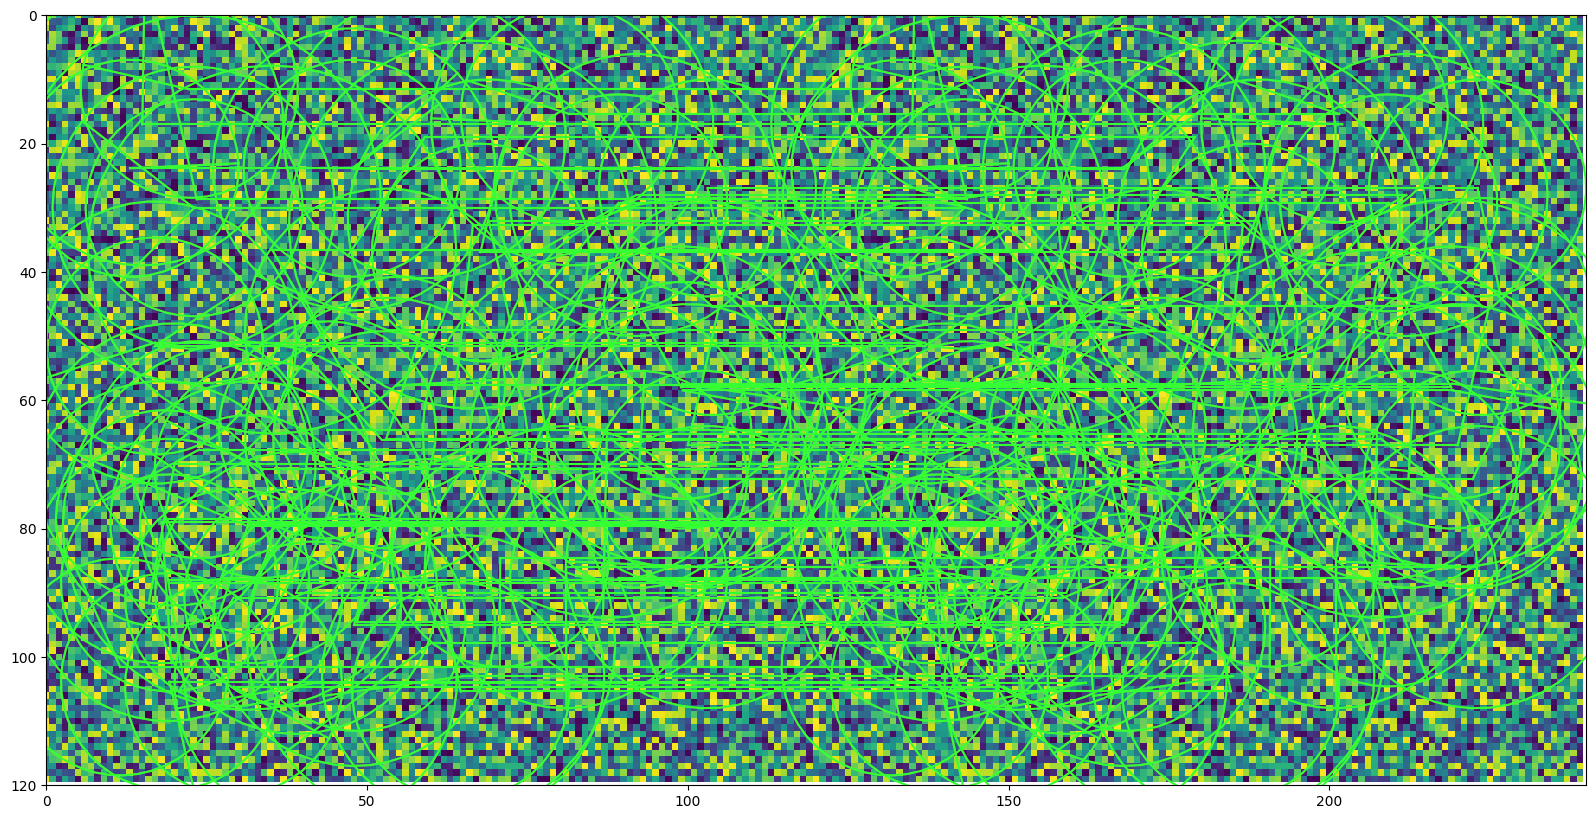

In [15]:
def detect_and_extract_features(image, detector, descriptor, PS):
    with torch.no_grad():
        lafs, resps = detector(image[None])
        patches = kornia.feature.extract_patches_from_pyramid(image[None], lafs, PS)
        B, N, CH, H, W = patches.size()
        descs = descriptor(patches.view(B * N, CH, H, W)).view(B, N, -1)
        return lafs, descs

def compute_homography(lafs1, lafs2, matches):
    src_pts = lafs1[0, matches[:, 0], :, 2].data.cpu().numpy()
    dst_pts = lafs2[0, matches[:, 1], :, 2].data.cpu().numpy()
    F, inliers_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 1.0, 0.999, 1000)
    inliers_point = matches[torch.from_numpy(inliers_mask).bool().squeeze(), :]
    return inliers_mask

print(timg_gray.device,timg_gray.shape)
with torch.no_grad():
    lafs1, descs1 = detect_and_extract_features(timg_gray[0],detector,descriptor,PS)
    
    lafs2, descs2 = detect_and_extract_features(timg_gray[1],detector,descriptor,PS)
    
    scores, matches = kornia.feature.match_snn(descs1[0], descs2[0], 0.9)
    
print(matches.shape)

if(matches.shape[0] < 4):
    print("No matches found")
else:
    # Cálculo da homografia
    inliers_mask = compute_homography(lafs1, lafs2, matches)
    print(lafs1[0][None].shape, lafs1[0].shape, matches.shape, inliers_mask.shape)

    from kornia_moons.viz import draw_LAF_matches

    draw_LAF_matches(
        lafs1[0][None].cpu(),
        lafs2[0][None].cpu(),
        matches.cpu(),
        kornia.tensor_to_image(timg_gray[0].cpu()),
        kornia.tensor_to_image(timg_gray[1].cpu()),
        inliers_mask,
        draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
    )